In [10]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [12]:
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

(1070994, 32)

In [9]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [6]:
data.tail()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,30,26,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,32,26,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,24,32,NaN,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,32,21,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1070993,1070994,5080500094,5,8050,94,NaN,EDWARD DONOHUE,A1,1,50,...,30,24,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


#### Removing properties that we are not interested in

In [166]:
#first look at the most frequent owners
remove_list = data['OWNER'].value_counts().head(20).index.tolist()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [167]:
#removeing some and adding some to be removed
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.append('UNITED STATES OF AMER')
remove_list.append('U S GOVERNMENT OWNRD')
remove_list.append('THE CITY OF NEW YORK')
remove_list.append('NYS URBAN DEVELOPMENT')
remove_list.append('NYS DEPT OF ENVIRONME')
remove_list.append('CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI')
remove_list.append('DEPT RE-CITY OF NY')
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 'LINCOLN PLAZA ASSOCIA',
 'UNITED STATES OF AMER',
 'U S GOVERNMENT OWNRD',
 'THE CITY OF NEW YORK',
 'NYS URBAN DEVELOPMENT',
 'NYS DEPT OF ENVIRONME',
 'CULTURAL AFFAIRS',
 'DEPT OF GENERAL SERVI',
 'DEPT RE-CITY OF NY']

In [168]:
property_data = data[-data['OWNER'].isin(remove_list)].reset_index(drop= True)
pd2 = property_data.copy()
property_data.shape

(1046826, 32)

In [169]:
numrecs = len(property_data)
ntop = 100

#### Fill in missing ZIP

In [170]:
# Count the zips that are missing and NAN with 0
missing_zips  = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21772

In [171]:
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [172]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10245

In [173]:
#For the remaining missing zips, just fill in with the previous record's zip.
for i in range (len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [174]:
missing_zips= np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

#### Filling in missing stories

In [175]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43968

In [176]:
temp['TAXCLASS'].value_counts()

1B    19055
4     17979
2      3434
3      2416
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [177]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
mean_stories

TAXCLASS
1      2.111633
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.744977
3      1.000000
4      5.517257
Name: STORIES, dtype: float64

In [178]:
len(property_data[property_data['STORIES']==0])

0

In [179]:
property_data['STORIES'] = property_data['STORIES'].fillna(value = 0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES'] = mean_stories[index]

#### Calculate means for AVOT, AVLAND,FULLVAL by taxclass, avoiding the records with zeros

In [180]:
property_data['FULLVAL'].replace('NaN',0)
temp = property_data[property_data['FULLVAL'] !=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
mean_fullval

TAXCLASS
1     5.700059e+05
1A    3.352942e+05
1B    3.738399e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723493e+05
3     8.510005e+04
4     2.772747e+06
Name: FULLVAL, dtype: float64

In [181]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()


In [182]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()


#### Subsetting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [183]:
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL'] = mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND'] = mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT'] = mean_avtot[index]

In [184]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


#### Fill in LTFRONT,LTDEPTH,BLDDEPTH,BLDFRONT with averages by TAXCLASS

In [185]:
# Because these 4 fields do not have NAs, we just need to replace 0s and the 1s. 
# We think zero and 1 are both  invalid values for these fields, so replace them with NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

# Now impute values with the average for that record's TAXCLASS
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]


In [186]:
mean_LTFRONT

TAXCLASS
1      30.939210
1A     51.130890
1B     46.316982
1C     27.250825
1D    338.275862
2     111.579150
2A     25.919459
2B     27.254800
2C     29.988866
3     154.473171
4      82.296384
Name: LTFRONT, dtype: float64

In [187]:
mean_LTDEPTH

TAXCLASS
1      99.279091
1A     90.095778
1B    103.993512
1C     96.778878
1D    497.827586
2     130.815876
2A     97.288381
2B     95.725639
2C     95.748523
3     274.124729
4     124.443774
Name: LTDEPTH, dtype: float64

In [188]:
mean_BLDFRONT

TAXCLASS
1     21.403255
1A    25.026348
1B    39.500000
1C    23.367589
1D    19.586207
2     91.495779
2A    22.985669
2B    26.033148
2C    27.887084
3     10.000000
4     62.082133
Name: BLDFRONT, dtype: float64

In [189]:
data = property_data.copy()
data.shape

(1046826, 32)

In [190]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [191]:
# convert ZIP to a string trather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]
data.count()

RECORD      1046826
BBLE        1046826
BORO        1046826
BLOCK       1046826
LOT         1046826
EASEMENT       2967
OWNER       1015081
BLDGCL      1046826
TAXCLASS    1046826
LTFRONT     1046826
LTDEPTH     1046826
EXT          353372
STORIES     1046826
FULLVAL     1046826
AVLAND      1046826
AVTOT       1046826
EXLAND      1046826
EXTOT       1046826
EXCD1        625308
STADDR      1046357
ZIP         1046826
EXMPTCL       10681
BLDFRONT    1046826
BLDDEPTH    1046826
AVLAND2      267417
AVTOT2       267423
EXLAND2       82371
EXTOT2       119371
EXCD2         92912
PERIOD      1046826
YEAR        1046826
VALTYPE     1046826
zip3        1046826
dtype: int64

In [192]:
cols = data.columns
cols

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')

#### variable building

In [193]:
data['ltsize']= data['LTFRONT']*data['LTDEPTH']
data['bldsize']= data['BLDFRONT']*data['BLDDEPTH']
data['bldvol']= data['bldsize']*data['STORIES']

In [194]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500.0,27.0,82.296384,82.296384,82.296384


In [195]:
data['r1']= data['FULLVAL']/data['ltsize']
data['r2']= data['FULLVAL']/data['bldsize']
data['r3']= data['FULLVAL']/data['bldvol']

data['r4']= data['AVLAND']/data['ltsize']
data['r5']= data['AVLAND']/data['bldsize']
data['r6']= data['AVLAND']/data['bldvol']

data['r7']= data['AVTOT']/data['ltsize']


data['r8']= data['AVTOT']/data['bldsize']


data['r9']= data['AVTOT']/data['bldvol']

In [196]:
# add in the inverse of all the 9 primary variables
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col])

In [197]:
ninevars = ['r1','r2','r3','r4','r5','r6','r7','r8','r9',
            'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']
zip5_mean = data.groupby('ZIP')[ninevars].mean()
zip3_mean = data.groupby('zip3')[ninevars].mean()
taxclass_mean = data.groupby('TAXCLASS')[ninevars].mean()
borough_mean = data.groupby('BORO')[ninevars].mean()
data = data.join(zip5_mean,on='ZIP', rsuffix = '_zip5')
data = data.join(zip3_mean,on='zip3', rsuffix = '_zip3')
data = data.join(taxclass_mean, on = 'TAXCLASS', rsuffix = '_taxclass')
data = data.join(borough_mean, on = 'BORO', rsuffix = '_boro')
rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']
for var in ninevars:
    for r in rsuffix:
        data[str(var)+r] = data[var]/data[str(var)+r]

In [198]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
...,...,...,...,...,...
r5inv_boro,0.000569,0.000168,0.003782,0.002617,0.002487
r6inv_boro,0.000147,0.000043,0.00883,0.00611,0.005805
r7inv_boro,0.106805,0.000076,0.011346,0.007851,0.004222
r8inv_boro,0.001731,0.000191,0.009388,0.006496,0.003494


In [199]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT',
       ...
       'r9_boro', 'r1inv_boro', 'r2inv_boro', 'r3inv_boro', 'r4inv_boro',
       'r5inv_boro', 'r6inv_boro', 'r7inv_boro', 'r8inv_boro', 'r9inv_boro'],
      dtype='object', length=126)

In [200]:
save_record = data['RECORD']
save_record.head()

0     1
1     2
2     9
3    10
4    11
Name: RECORD, dtype: int64

In [201]:
dropcols = ['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1046826, 90)

In [202]:
data.head().transpose()

,0,1,2,3,4
r1,40.917782,57678.882190,385.182796,556.662267,1035.027624
r2,3994.412456,36173.697854,736.308714,1064.105879,1978.540749
r3,723.985188,6556.463990,14.726174,21.282118,39.570815
r4,8.079350,4258.951518,62.110738,89.761892,94.470682
r5,788.709805,2671.030012,118.729804,171.587267,180.588507
...,...,...,...,...,...
r5inv_boro,0.000569,0.000168,0.003782,0.002617,0.002487
r6inv_boro,0.000147,0.000043,0.008830,0.006110,0.005805
r7inv_boro,0.106805,0.000076,0.011346,0.007851,0.004222
r8inv_boro,0.001731,0.000191,0.009388,0.006496,0.003494


In [203]:
stats = data.describe().transpose()
stats.to_excel('stats_on_vars.xlsx')

In [204]:
data.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r9_boro,r1inv_boro,r2inv_boro,r3inv_boro,r4inv_boro,r5inv_boro,r6inv_boro,r7inv_boro,r8inv_boro,r9inv_boro
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,...,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,2.135691e+02,5.364155e+02,2.440821e+02,1.046467e+01,2.281677e+01,1.004138e+01,2.683329e+01,5.046225e+01,1.907402e+01,1.131511e-01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,5.325639e+02,1.027443e+03,4.988230e+02,6.997586e+01,3.785065e+02,1.783286e+02,2.038739e+02,9.322000e+02,3.270238e+02,5.806045e+00,...,1.572688e+01,5.725092e+01,4.466163e+01,4.778748e+01,5.090181e+01,1.959085e+01,2.941052e+01,6.264512e+01,2.475668e+01,2.160514e+01
min,3.905765e-04,7.466192e-04,8.983394e-05,8.333333e-06,2.096125e-04,1.038033e-05,8.333333e-06,3.062474e-04,6.049251e-05,7.213064e-06,...,2.777226e-06,3.022904e-05,3.164322e-05,3.083654e-06,1.382444e-05,4.150239e-06,4.480255e-07,9.526489e-06,4.229670e-06,2.655153e-06
25%,7.626263e+01,2.118164e+02,8.250000e+01,2.354081e+00,6.204263e+00,2.015872e+00,5.281000e+00,1.746754e+01,7.089338e+00,4.112150e-03,...,3.906492e-01,4.793202e-02,2.866668e-02,6.645456e-03,8.307361e-02,5.733016e-02,1.350440e-02,1.464240e-01,8.238668e-02,3.214915e-02
50%,1.528571e+02,5.000000e+02,2.390625e+02,4.596931e+00,1.498098e+01,7.146888e+00,8.579254e+00,2.697736e+01,1.267829e+01,6.542056e-03,...,6.729240e-01,7.304364e-02,4.186098e-02,1.070110e-02,1.409591e-01,7.915880e-02,2.405543e-02,2.982497e-01,1.267765e-01,5.180770e-02
75%,2.431818e+02,6.838235e+02,3.362314e+02,7.225445e+00,2.028646e+01,1.004363e+01,1.352700e+01,3.600000e+01,1.757576e+01,1.311258e-02,...,9.393327e-01,1.399090e-01,8.763088e-02,2.546326e-02,2.591898e-01,1.497378e-01,5.473397e-02,4.890672e-01,2.054876e-01,8.663041e-02
max,1.386373e+05,3.105516e+05,2.275000e+05,2.224980e+04,3.346364e+05,1.115455e+05,6.471185e+04,8.713622e+05,2.904541e+05,2.560318e+03,...,1.381933e+04,3.571187e+04,3.279601e+04,3.711074e+04,4.817898e+04,3.428855e+03,3.095585e+03,5.918176e+04,1.379716e+04,1.030168e+04


#### Z scale the variables before PCA

In [205]:
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r9_boro,r1inv_boro,r2inv_boro,r3inv_boro,r4inv_boro,r5inv_boro,r6inv_boro,r7inv_boro,r8inv_boro,r9inv_boro
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,...,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,-1.836969e-14,-3.051849e-14,-3.560872e-14,7.322379e-16,2.313336e-15,1.985216e-15,-4.578153e-14,-1.491621e-15,-3.817431e-15,-4.955384e-15,...,-2.853678e-15,1.881018e-15,-1.875485e-16,9.501514e-16,6.790699e-16,-1.316008e-15,-2.354103e-16,-8.807344e-16,3.048242e-15,8.769486e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.010199e-01,-5.220872e-01,-4.893158e-01,-1.495467e-01,-6.028049e-02,-5.630825e-02,-1.316171e-01,-5.413210e-02,-5.832592e-02,-1.948726e-02,...,-6.358523e-02,-1.746644e-02,-2.238987e-02,-2.092592e-02,-1.964540e-02,-5.104402e-02,-3.400143e-02,-1.596278e-02,-4.039296e-02,-4.628516e-02
25%,-2.578217e-01,-3.159291e-01,-3.239267e-01,-1.159055e-01,-4.388961e-02,-4.500406e-02,-1.057139e-01,-3.539445e-02,-3.664775e-02,-1.878025e-02,...,-3.874582e-02,-1.662974e-02,-2.174872e-02,-2.078692e-02,-1.801363e-02,-4.811786e-02,-3.354228e-02,-1.362558e-02,-3.706528e-02,-4.479725e-02
50%,-1.139995e-01,-3.544288e-02,-1.006284e-02,-8.385372e-02,-2.070184e-02,-1.623124e-02,-8.953595e-02,-2.519297e-02,-1.955740e-02,-1.836174e-02,...,-2.079726e-02,-1.619112e-02,-2.145329e-02,-2.070205e-02,-1.687643e-02,-4.700363e-02,-3.318353e-02,-1.120199e-02,-3.527223e-02,-4.388735e-02
75%,5.560400e-02,1.434707e-01,1.847335e-01,-4.629056e-02,-6.684979e-03,1.259701e-05,-6.526729e-02,-1.551410e-02,-4.581517e-03,-1.723007e-02,...,-3.857554e-03,-1.502318e-02,-2.042848e-02,-2.039314e-02,-1.455371e-02,-4.340098e-02,-3.214041e-02,-8.155987e-03,-3.209285e-02,-4.227557e-02
max,2.599196e+02,3.017347e+02,4.555842e+02,3.178144e+02,8.840365e+02,6.254489e+02,3.172796e+02,9.346833e+02,8.881159e+02,4.409551e+02,...,8.786441e+02,6.237607e+02,7.342993e+02,7.765578e+02,9.464886e+02,1.749722e+02,1.052204e+02,9.446987e+02,5.572700e+02,4.767697e+02


#### First compute many of the PC componets and look at the scree plot


(0.0, 1.0)

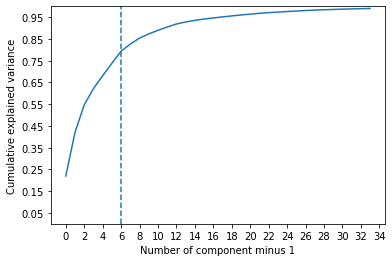

In [206]:
#do a PCA and look at the cumulative varaince plot
pca = PCA(n_components = .99,svd_solver = 'full')
pca.fit(data_zs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of component minus 1')
plt.ylabel('Cumulative explained variance')
plt.xticks(np.arange(0,36,step = 2))
plt.yticks(np.arange(0.05, 1.1, step =.1))
plt.axvline(x=6, linestyle = '--')
plt.ylim(0,1)

#### Now decide to keep just 7 PCs. Recompute them

In [207]:
# Now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 7,svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

7

#### Z scale the PCs to make them all equally important 

In [208]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range (1, pca.n_components_+1)])
data_pca.shape
#zscale the pcs
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,-9.728801e-16,8.893581e-17,-2.042925e-15,4.221622e-17,6.477318e-16,-9.458869e-16,-1.042751e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.154774e+01,-8.573855e-02,-2.271146e+02,-2.768935e+02,-3.038236e+02,-2.309228e+02,-3.262506e+02
25%,-1.035809e-01,-5.075447e-02,-1.541659e-01,-2.528747e-03,-2.124467e-02,-1.331751e-01,-1.281902e-01
50%,-1.765195e-02,-4.468804e-02,-6.029215e-02,2.628768e-03,1.010517e-02,-1.768679e-02,-3.069640e-02
75%,3.924282e-02,-3.575819e-02,3.102926e-02,9.351279e-03,3.161665e-02,2.740942e-01,3.935591e-02
max,6.825822e+02,3.958843e+02,3.240133e+02,8.218831e+02,4.419954e+02,5.184597e+02,3.489697e+02


#### Creating Fraud Models
#### Model 1 z score outliers

In [209]:
p1 = 2
oop1 = 1 /p1
score1 = (((data_pca_zs).abs()** p1).sum(axis = 1))** oop1
score1.head(10)

0     3.111159
1    69.235492
2     0.273789
3     0.469062
4     1.070884
5     0.428559
6     0.284815
7     0.295393
8     0.764182
9     0.733115
dtype: float64

#### Model 2 Autoencoder error

In [210]:
NNmodel = MLPRegressor(hidden_layer_sizes = (10) , activation = 'relu', verbose = True, max_iter = 15, random_state =1 )
NNmodel.fit(data_pca_zs, data_pca_zs)


Iteration 1, loss = 0.31203909
Iteration 2, loss = 0.15880255
Iteration 3, loss = 0.10783790
Iteration 4, loss = 0.08697483
Iteration 5, loss = 0.05928352
Iteration 6, loss = 0.03834116
Iteration 7, loss = 0.02695220
Iteration 8, loss = 0.01765546
Iteration 9, loss = 0.01269320
Iteration 10, loss = 0.00949307
Iteration 11, loss = 0.00595564
Iteration 12, loss = 0.00330296
Iteration 13, loss = 0.00309626
Iteration 14, loss = 0.00168802
Iteration 15, loss = 0.00106744


C:\Users\saman\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=10, max_iter=15, random_state=1, verbose=True)

In [211]:
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
p2 = 2
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis =1))**oop2

In [212]:
score2.head(10)

0    0.032713
1    1.062363
2    0.023396
3    0.025584
4    0.030607
5    0.018652
6    0.021399
7    0.021219
8    0.028483
9    0.028171
dtype: float64

#### Combining the two scores

In [213]:
scores = pd.DataFrame(score1)
scores.rename(columns = {0:'score1'}, inplace = True)
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
top_records = scores.sort_values(['final'],ascending =False).head(30).index
top_records

Int64Index([ 975628,  898846,  675033,  701673,  633064, 1031078,  759739,
             936080,  642176,    7010,  974507,    7016,    7015,    7014,
               7013,    7012,    7011,    7018,    7017,    7009,    7019,
             444326,  914593,  232192,  113171, 1036415, 1026195,  827753,
             231106,  979841],
           dtype='int64')

In [214]:
scores

,score1,score2,score1 rank,score2 rank,final
0,3.111159,0.032713,1033738.0,924622.0,979180.0
1,69.235492,1.062363,1046696.0,1046048.0,1046372.0
2,0.273789,0.023396,573498.0,762788.0,668143.0
3,0.469062,0.025584,752401.0,809187.0,780794.0
4,1.070884,0.030607,1004165.0,900752.0,952458.5
...,...,...,...,...,...
1046821,0.211109,0.009484,463522.0,372292.0,417907.0
1046822,0.291675,0.042135,594743.0,973934.0,784338.5
1046823,0.286916,0.026401,589387.0,826518.0,707952.5
1046824,0.352972,0.012625,653958.0,493754.0,573856.0


In [215]:
score1.max()

940.8780022137546

(0.1, 2089149.628010629)

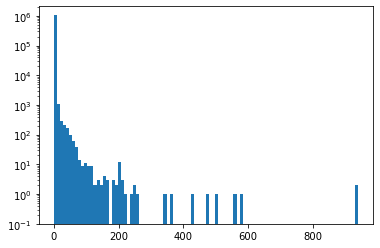

In [216]:
sclmax = int(score1.max())
plt.hist(score1, bins = 100, range = (0,sclmax+1))
plt.yscale('log')
plt.ylim(ymin =.1)

In [217]:
sc2max = int(score2.max())
sc2max

220

In [218]:
#df22 = property_data.copy()
#df23 = pd.concat([pd2, scores], axis=1)
pd2["score1 rank"] = scores["score1 rank"]
pd2["score2 rank"] = scores["score2 rank"]

pd2["final"] = scores["final"]
pd3 = pd2.loc[top_records]
pd3

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
975628,996722,5029220125,5,2922,125,NaN,IMPERIAL COURT HOMEOW,V0,1B,300,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046825.0,1046826.0,1046825.5
898846,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1046826.0,1046825.0,1046825.5
675033,691986,4039160200,4,3916,200,NaN,TITAN SOUNDVIEW POINT,Z7,4,0,...,3.000000e+00,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046824.0,1046823.0,1046823.5
701673,718883,4051251107,4,5125,1107,NaN,GARDEN VIEW LTD,R4,2,0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046822.0,1046821.0,1046821.5
633064,649717,4025270002,4,2527,2,NaN,57-43 LLC,V1,4,51,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046819.0,1046824.0,1046821.5
1031078,1053859,5064310100,5,6431,100,NaN,NaN,Z7,4,1000,...,1.390000e+02,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046810.0,1046822.0,1046816.0
759739,777200,4080990145E,4,8099,145,E,NY STATE PUBLIC WORKS,Z7,4,110,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046817.0,1046808.0,1046812.5
936080,956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046823.0,1046798.0,1046810.5
642176,658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046820.0,1046799.0,1046809.5
7010,7034,1000531146,1,53,1146,NaN,"HSIA, JONATHAN",R4,2,0,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046803.0,1046815.0,1046809.0


In [220]:
pd3.to_excel("HW3.xlsx")

In [222]:
pd3.shape

(30, 35)